In [1]:
!pip install tensorflow
!pip install tsfresh
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import scipy.io
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output
import tsfel

In [2]:
batch1 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [3]:
numBat1 = len(batch1.keys())
numBat1

41

In [4]:
batch2 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch3.pkl','rb'))
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [5]:
numBat2 = len(batch2.keys())
numBat2
batch3 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch2.pkl','rb'))

numBat3 = len(batch3.keys())
numBat3
numBat = numBat1 + numBat2 + numBat3
numBat

135

In [6]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

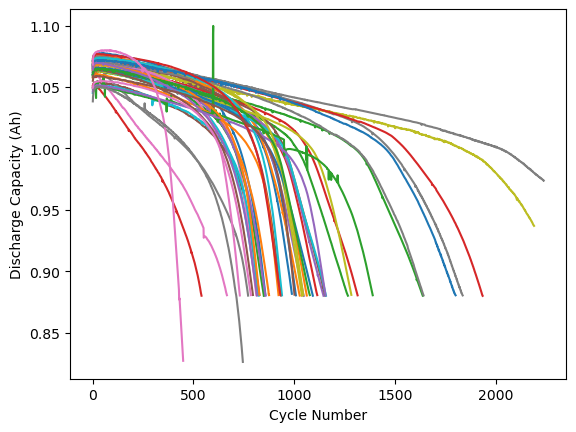

In [7]:
for i in bat_dict.keys():
  plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [8]:
bat_dict_keys = bat_dict.keys()

In [9]:
RUL = []

for i in bat_dict_keys:
  
    cell = bat_dict[i]
    #len_summary_cycle = len(cell['summary']['cycle'])
    cycle_life = int(cell['summary']['cycle'][-1])
    for j in range(1,cycle_life):
        RUL.append(cycle_life-j)

In [10]:
len(RUL)

52153

In [11]:
def linear_interpolation(x, y, start, end, x_lin):
    x = x[start:end]
    y = y[start:end]
    f = interp1d(x,y)
    datalin = f(x_lin)
    datalin = smooth_curve(datalin)
    
    return(datalin)

In [12]:
def smooth_curve(points, factor=0.6):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [44]:
cycle_vector_features = (['Idlin', 
                          'Qdlin', 
                          'Tdlin', 
                          'dQdV']
                         )

# Liste des features scalaires
cycle_scalar_features = (['IR', 
                          'Tavg', 
                          'Tmin', 
                          'Tmax', 
                          'QC', 
                          'QD', 
                          'SOH', 
                          'chargetime'])

# Définition des différentes matrices qui vont contenir les données d'entrainement

# matrice vectorielle 
cycle_vector_dataset_arr = np.zeros((len(RUL), len(cycle_vector_features), 200)) 
# matrice scalaire
cycle_scalar_dataset_arr = np.zeros((len(RUL), len(cycle_scalar_features))) 
# matrice commune vectorielle/scalaire
cycle_dataset_arr = (np.empty((len(RUL), 
                               len(cycle_vector_features)+len(cycle_scalar_features), 
                               200))) 
cycle_dataset_arr[:] = np.NaN
V=[]
I=[]
T=[]

# Définition des différents dictionnaires qui vont contenir les données d'entrainement
cycle_vector_dataset_dict = {} #dictionnaire vectoriel
cycle_scalar_dataset_dict = {} #dictionnaire scalaire
global_dataset = {} # dictionnaire commun vectoriel/scalaire

s=0 # la variable s compte le nombre d'échantillons dans le dataset
for i in bat_dict_keys : # On parcourt toutes les cellules du dataset brut
    clear_output(wait=True)
    cell = bat_dict[i]   
    print('cell:', i) #affichage de la cellule de batterie en cours 
    cycle_life = len(cell['summary']['cycle'])
    
    for j in range(1,cycle_life): # on parcourt tous les cycles de la cellule 
        
        # récupération des données vectorielles 
        # on ne récupère que les données de décharge
        
        start_discharge = np.where(cell['cycles'][str(j)]['I'] < -0.05) # Début de la décharge
        start_discharge = start_discharge[0][0]
        
        end_discharge = np.where(cell['cycles'][str(j)]['I'] < -3.9) # Fin de la décharge
        end_discharge = end_discharge[0][-1]
   
        
        
        
        
        Vmin = min(cell['cycles'][str(j)]['V'][start_discharge:end_discharge]) 
        Vmax = max(cell['cycles'][str(j)]['V'][start_discharge:end_discharge])
        
        x_discharge = np.linspace(Vmax,Vmin,200) # Vecteur de référence à partir duquel 
                                                 # l'interpolation linéaire est réalisée
            
        # interpolation linéaire du courant, capacité de décharge et température   
        Idlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['I'], \
                                     start_discharge, end_discharge, x_discharge)
        Qdlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['Qd'], \
                                     start_discharge, end_discharge, x_discharge)
        Tdlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['T'], \
                                     start_discharge, end_discharge, x_discharge)
        V.append(cell['cycles'][str(j)]['V'])
        I.append(cell['cycles'][str(j)]['I'])
        T.append(cell['cycles'][str(j)]['T'])
        
        # interpolation linéaire de dQdV 
        g = interp1d(np.linspace(Vmax,Vmin,1000), cell['cycles'][str(j)]['dQdV'])
        dQdV = g(x_discharge)
        
        # Les vecteurs sont regroupés dans la matrice vectorielle
        cycle_vector_dataset_arr[s+j-1][0] = Idlin
        cycle_vector_dataset_arr[s+j-1][1] = Qdlin
        cycle_vector_dataset_arr[s+j-1][2] = Tdlin
        cycle_vector_dataset_arr[s+j-1][3] = dQdV
       
        # les vecteurs sont également regroupés dans la matrice globale
        cycle_dataset_arr[s+j-1][0] = Idlin
        cycle_dataset_arr[s+j-1][1] = Qdlin
        cycle_dataset_arr[s+j-1][2] = Tdlin
        cycle_dataset_arr[s+j-1][3] = dQdV
      
        
        # Un dictionnaire "échantillon" contenant uniquement 
        # les vecteurs de ce cycle est créé
        vector_sample_dict = ({'Idlin' : Idlin, 
                               'Qdlin' : Qdlin, 
                               'Tdlin' : Tdlin,
                               'dQdV'  : dQdV  
                                }
                             )
        
        # Récupération des données scalaires
        IR = cell['summary']['IR'][j]
        Tavg = cell['summary']['Tavg'][j]
        Tmin = cell['summary']['Tmin'][j]
        Tmax = cell['summary']['Tmax'][j]
        QC = cell['summary']['QC'][j]
        QD = cell['summary']['QD'][j]
        chargetime = cell['summary']['chargetime'][j]
        SOH = (QD/cell['summary']['QD'][1])*100 
        
        # Les scalaires sont regroupés dans la matrice scalaire
        cycle_scalar_dataset_arr[s+j-1][0] = IR
        cycle_scalar_dataset_arr[s+j-1][1] = Tavg
        cycle_scalar_dataset_arr[s+j-1][2] = Tmin
        cycle_scalar_dataset_arr[s+j-1][3] = Tmax
        cycle_scalar_dataset_arr[s+j-1][4] = QC
        cycle_scalar_dataset_arr[s+j-1][5] = QD
        cycle_scalar_dataset_arr[s+j-1][6] = chargetime
        cycle_scalar_dataset_arr[s+j-1][7] = SOH
        
        # Les scalaires sont également ajoutés 
        # à la suite des vecteurs dans la matrice globale
        cycle_dataset_arr[s+j-1][4][0] = IR
        cycle_dataset_arr[s+j-1][5][0] = Tavg
        cycle_dataset_arr[s+j-1][6][0] = Tmin
        cycle_dataset_arr[s+j-1][7][0] = Tmax
        cycle_dataset_arr[s+j-1][8][0] = QC
        cycle_dataset_arr[s+j-1][9][0] = QD
        cycle_dataset_arr[s+j-1][10][0] = chargetime
        cycle_dataset_arr[s+j-1][11][0] = SOH
                
        # Un dictionnaire "échantillon" contenant uniquement 
        # les scalaires de ce cycle est créé
        scalar_sample_dict = ({'IR': IR , 
                               'Tavg': Tavg , 
                               'Tmin' : Tmin , 
                               'Tmax' : Tmax , 
                               'QC': QC, 
                               'QD':QD, 
                               'chargetime':chargetime, 
                               'SOH':SOH}
                             )
        
        # Les deux dictionnaires échantillons (vectoriel et scalaire) sont  
        # regroupés dans un dictionnaire échantillon global contenant 
        # à la fois les vecteurs et les scalaires de ce cycle
        global_sample_dict = {**vector_sample_dict, **scalar_sample_dict}
    
        # Attribution d'un intitulé à chaque échantillon
        dict_key = "{}_cycle_{}".format(i,j) 
        
        # Le dictionnaire échantillon vectoriel est ajouté au dictionnaire vectoriel
        # contenant les vecteurs de tous les cycles
        cycle_scalar_dataset_dict[dict_key] = scalar_sample_dict
        
        # Le dictionnaire échantillon scalaire est ajouté au dictionnaire scalaire
        # contenant les scalaires de tous les cycles
        cycle_vector_dataset_dict[dict_key] = vector_sample_dict
        
        # Le dictionnaire échantillon global est ajouté au dictionnaire global 
        # contenant les vecteurs et les scalaires de chaque cycle
        global_dataset[dict_key] = global_sample_dict
        
    s+=j # s représente le numéro de l'échantillon créé 
print('all cycles from batches 1, 2 and 3 were browsed')

cell: b1c47
all cycles from batches 1, 2 and 3 were browsed


In [45]:
cycle_vector_dataset_df = pd.DataFrame(cycle_vector_dataset_dict)

# Création d'un dataframe scalaire
cycle_scalar_dataset_df = pd.DataFrame(cycle_scalar_dataset_dict)

#Création d'un dataframe global
cycle_dataset_df = pd.DataFrame(global_dataset)

In [46]:
df=pd.DataFrame({"I":I,"V":V,"T":T,"SOH":cycle_dataset_df.T["SOH"]})

In [47]:
df

,I,V,T,SOH
b1c0_cycle_1,"[0.39175900909090905, 0.7491510545454545, 1.04...","[2.1120076, 2.1413512, 2.1740165, 2.2118678, 2...","[32.095115420451435, 32.09553350772601, 32.095...",100.0
b1c0_cycle_2,"[0.5479257727272726, 0.7937517999999999, 1.098...","[2.1213861, 2.1444716, 2.1782861, 2.2177253, 2...","[32.100925, 32.100489412344736, 32.10002811787...",100.077736
b1c0_cycle_3,"[0.39319471818181817, 0.648456918181818, 0.948...","[2.1124139, 2.1327176, 2.1629434, 2.1995873, 2...","[32.213660487082265, 32.21347621404638, 32.213...",100.11741
b1c0_cycle_4,"[0.4450329909090909, 0.6991507818181818, 1.101...","[2.1151195, 2.1360803, 2.1796918, 2.2119021, 2...","[32.13458411412274, 32.134207367490596, 32.133...",100.153496
b1c0_cycle_5,"[0.5985780181818181, 0.8996131181818181, 1.149...","[2.1280026, 2.1573977, 2.1868119, 2.2334542, 2...","[32.0781864326378, 32.07801845032766, 32.07785...",100.183605
...,...,...,...,...
b1c47_cycle_740,"[0.0, 0.2995092181818182, 0.4784115909090909, ...","[2.4366145, 2.4486165, 2.4607921, 2.4731212, 2...","[30.858965, 30.858965, 30.858965, 30.858965, 3...",80.074365
b1c47_cycle_741,"[0.0, 0.2390670818181818, 0.478279809090909, 0...","[2.4453759, 2.4552312, 2.4685254, 2.4812427, 2...","[30.924057, 30.924057, 30.924057, 30.924057, 3...",79.849397
b1c47_cycle_742,"[0.0, 0.29942946363636364, 0.5394571454545454,...","[2.452889, 2.4650865, 2.47963, 2.4921498, 2.50...","[31.010826, 31.010826, 31.010826, 31.010826, 3...",79.691859
b1c47_cycle_743,"[0.0, 0.29693949999999997, 0.5387843727272726,...","[2.4562917, 2.4697738, 2.4833999, 2.4961963, 2...","[31.052486, 31.052486, 31.052486, 31.052486, 3...",79.485376


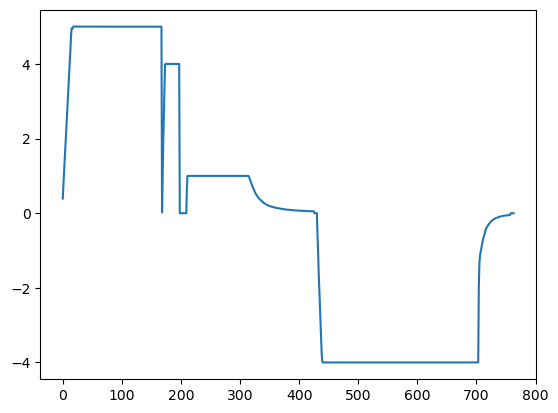

In [57]:
plt.plot(range(len(df["I"]["b1c0_cycle_1"])),df["I"]["b1c0_cycle_1"])
plt.show()



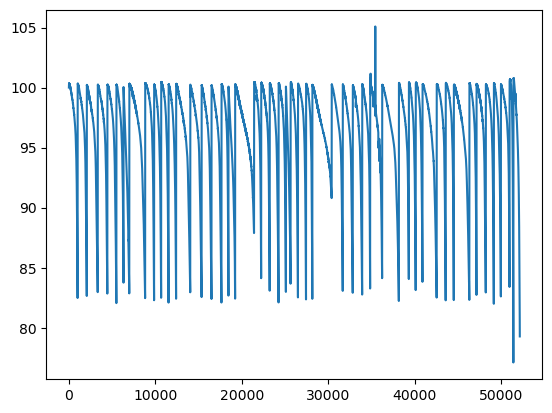

In [58]:
plt.plot(range(len(df["SOH"])),df["SOH"])
plt.show()

In [55]:
df["I"]["b1c0_cycle_1"].plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

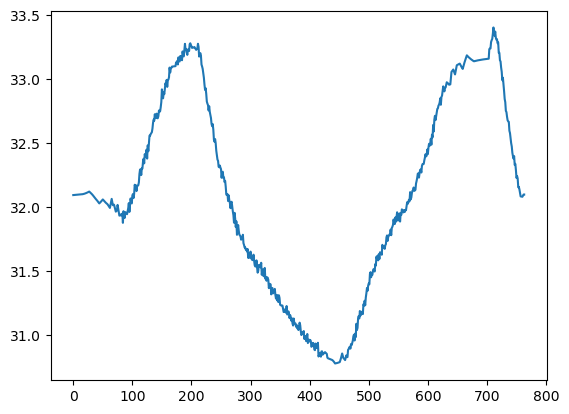

In [17]:
plt.plot(range(len(T[0])),T[0])
plt.show()

In [18]:
for i in df.index:
    df["I"][i]= df["I"][i][0:700]
    df["V"][i]= df["V"][i][0:700]
    df["T"][i]= df["T"][i][0:700]

In [19]:
imax=[]
imin=[]
iavg=[]
vmax=[]
vmin=[]
vavg=[]
tmax=[]
tmin=[]
tavg=[]
for i in df.index:
    imax.append(max(df["I"][i]))
    imin.append(min(df["I"][i]))
    iavg.append(np.average(df["I"][i]))
    vmax.append(max(df["V"][i]))
    vmin.append(min(df["V"][i]))
    vavg.append(np.average(df["V"][i]))
    tmax.append(max(df["T"][i]))
    tmin.append(min(df["T"][i]))
    tavg.append(np.average(df["T"][i]))
   
   

In [20]:

df["Iavg"]=iavg

df["Vavg"]=vavg

df["Tavg"]=tavg

In [21]:
df=df.drop(["I","T","V"],axis=1)

In [22]:
def split_sequence(sequence, n_steps_in, n_steps_out):
   X=[]
   y=[]
   for i in range(len(sequence)):
       # find the end of this pattern
       end_ix = i + n_steps_in
       out_end_ix = end_ix + n_steps_out
 # check if we are beyond the sequence
       if out_end_ix > len(sequence):
              break
 # gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
       X.append(seq_x.drop(["SOH"],axis=1))
       y.append(seq_y["SOH"])
   return X, y

In [23]:
train_size=int(0.6*len(df))
train_data=df[0:train_size]
test_data=df[train_size:len(df)]

In [24]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
X_train,Y_train=split_sequence(train_data,10,1)
X_test,Y_test=split_sequence(test_data,10,1)

In [25]:
X_train[0]

,Iavg,Vavg,Tavg
b1c0_cycle_1,-0.029418,3.223558,32.045875
b1c0_cycle_2,-0.044400,3.217764,32.030345
b1c0_cycle_3,-0.037937,3.220249,32.026794
b1c0_cycle_4,-0.047502,3.215890,31.985082
b1c0_cycle_5,-0.061563,3.213177,31.954392
b1c0_cycle_6,-0.056575,3.210997,31.989815
b1c0_cycle_7,-0.057680,3.208736,32.011966
b1c0_cycle_8,-0.046316,3.212979,32.020509
b1c0_cycle_9,-0.044007,3.216033,32.012779
b1c0_cycle_10,-0.031029,3.214420,31.999196


In [26]:
size1=len(X_train)
size2=len(X_test)
X1=np.zeros((size1,10,3))
Y1=np.zeros(size1)
for i in range(size1):
   X1[i]=X_train[i]
   Y1[i]=Y_train[i]
X2=np.zeros((size2,10,3))
Y2=np.zeros(size2)
for i in range(size2):
   X2[i]=X_test[i]
   Y2[i]=Y_test[i]

In [27]:
X1[0]

array([[-2.94179308e-02,  3.22355816e+00,  3.20458753e+01],
       [-4.44000127e-02,  3.21776418e+00,  3.20303446e+01],
       [-3.79373913e-02,  3.22024882e+00,  3.20267936e+01],
       [-4.75023221e-02,  3.21589022e+00,  3.19850819e+01],
       [-6.15630890e-02,  3.21317660e+00,  3.19543924e+01],
       [-5.65749886e-02,  3.21099686e+00,  3.19898149e+01],
       [-5.76802124e-02,  3.20873630e+00,  3.20119663e+01],
       [-4.63160477e-02,  3.21297877e+00,  3.20205086e+01],
       [-4.40073317e-02,  3.21603318e+00,  3.20127788e+01],
       [-3.10285689e-02,  3.21441951e+00,  3.19991958e+01]])

In [28]:
def createModel(num_steps,inputShape,output):
# define model
     model = Sequential()
     model.add(LSTM(32, input_shape=(num_steps, inputShape)))
     model.add(Dense(output))
     model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])
     return model

In [29]:
model=createModel(X1.shape[1],X1.shape[2],1)

In [30]:
model.fit(X1, Y1, epochs=10, verbose=1,batch_size=64,validation_data=(X2,Y2))

Epoch 1/10
489/489 [==============================] - 2s 3ms/step - loss: 7087.5293 - mse: 7087.5293 - val_loss: 5596.6465 - val_mse: 5596.6465
Epoch 2/10
489/489 [==============================] - 1s 3ms/step - loss: 4613.8862 - mse: 4613.8862 - val_loss: 3753.5212 - val_mse: 3753.5212
Epoch 3/10
489/489 [==============================] - 1s 3ms/step - loss: 3043.2209 - mse: 3043.2209 - val_loss: 2422.1765 - val_mse: 2422.1765
Epoch 4/10
489/489 [==============================] - 1s 3ms/step - loss: 1913.8339 - mse: 1913.8339 - val_loss: 1476.4380 - val_mse: 1476.4380
Epoch 5/10
489/489 [==============================] - 1s 3ms/step - loss: 1127.4677 - mse: 1127.4677 - val_loss: 834.6187 - val_mse: 834.6187
Epoch 6/10
489/489 [==============================] - 1s 3ms/step - loss: 610.0811 - mse: 610.0811 - val_loss: 428.5280 - val_mse: 428.5280
Epoch 7/10
489/489 [==============================] - 1s 3ms/step - loss: 296.9644 - mse: 296.9644 - val_loss: 196.3350 - val_mse: 196.3350
Ep

In [31]:
yp=model.predict(X2[0:1])

1/1 [==============================] - 0s 172ms/step


In [32]:
np.shape(yp)

(1, 1)

In [33]:
Y2[0]

96.27755896600118

In [34]:
input=X2[0:1]
input=input.reshape(10,3)

In [35]:
model.save('my_lstm_model_2.h5')

In [36]:
np.save("X1",X1)
np.save("X2",X2)
np.save("Y1",Y1)
np.save("Y2",Y2)

In [37]:
np.save("test",test_data)